# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to describe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

# Solution

As it is mentioned on the page provided for dataset downloading [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3): "The links below do not work anymore. Please use the Kaggle link above to download the dataset".

So, we will use dataset provided by Kaggle and a whole task will be solved on the Kaggle platform. New notebook file was created on the [TuSimple dataset page](https://www.kaggle.com/datasets/manideep1108/tusimple) with built-in dataset (see picture below). Path to the dataset is "/kaggle/input/tusimple". Therefore, it is easy to operate with 23 GB of the data.
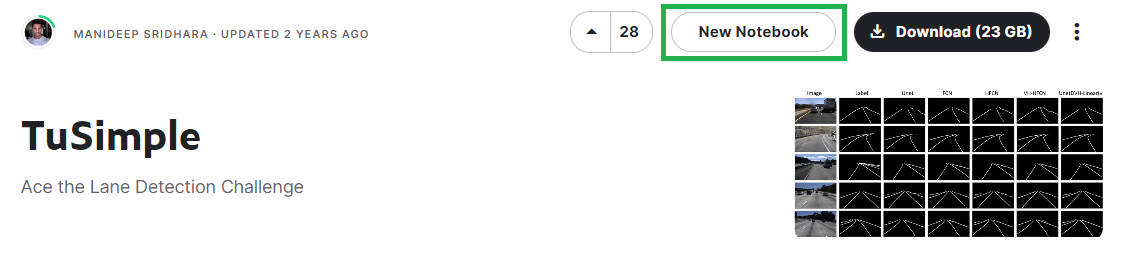

## Semantic and Segmentation Code

In the following cells you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the **labeling format**.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

### Implementation of class _`LaneDataset`_

In [4]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import tqdm

Let us explore the content of the `train_set` folder.

In [5]:
print(*[file for file in os.listdir('/kaggle/input/tusimple/TUSimple/train_set')], sep='\n')

readme.md
clips
label_data_0601.json
label_data_0313.json
label_data_0531.json
seg_label


Let us familiarize ourselves with the labeling format (information about it is in `readme.md` file).

In [6]:
with open('/kaggle/input/tusimple/TUSimple/train_set/readme.md', encoding='utf8') as file:
    print(*[line.rstrip() for line in file], sep='\n')

# TuSimple Lane Detection Challenge - Training Dataset

## Description
The lane marking is the main component on the highway. It instructs the vehicles interactively and safely drive on the highway. Lane detection is a critical task in autonomous driving, which provides localization information to the control of the car. We provide video clips for this task, and the last frame of each clip contains labelled lanes. The video clip can help algorithms to infer better lane detection results.

## Dataset Size
3626 video clips, 3626 labelled frames.
Information of each clip: 20 frames for each one.

## Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----some_clip/			# Sequential images for the clip, 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data 

Thus, the labeling format is as follows:

```python
__Format__
    {
      'raw_file': str. Clip file path.
      'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
      'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])
    }
```
So now we got pretty much everything to implement customized dataset.

**Note:** in Webinar, dedicated to the Final project, was said that it is allowed to borrow some ideas or pieces of open source code if links to them are provided. So here and there we will use fragments of open source code and alter them for our task, providing links for reference.

It is well known that it is better to split dataset into three parts: training, validation and test. Since in the iniitial dataset there are only `train_set` and `test_set`, we will include flag `train` to distinguish between training and validation datasets. For that we will have to compute the total amount of pictures in the `train_set` folder.

In [7]:
# Computing sizes of training and test datasets 
train_set_size = {}
train_set_path = '/kaggle/input/tusimple/TUSimple/train_set/clips'

for folder in os.listdir('/kaggle/input/tusimple/TUSimple/train_set/clips'):
    subfolders = len(os.listdir(f'/kaggle/input/tusimple/TUSimple/train_set/clips/{folder}'))
    train_set_size[folder] = subfolders * 20
    print(f"Folder {folder} contains {subfolders * 20} images.")
    
total_number_files = sum(train_set_size.values())

print(f'\nTotal number of images in the `train_set`: {total_number_files}.\n\n')

test_set_size = {}
test_set_path = '/kaggle/input/tusimple/TUSimple/test_set/clips/'
for folder in os.listdir(test_set_path):
    subfolders = len(os.listdir(f'{test_set_path + folder}'))
    test_set_size[folder] = subfolders * 20
    print(f"Folder {folder} contains {subfolders * 20} images.")
    
total_number_files = sum(test_set_size.values())

print(f'\nTotal number of images in the `test_set`: {total_number_files}.')


Folder 0531 contains 7160 images.
Folder 0601 contains 8200 images.
Folder 0313-2 contains 30060 images.
Folder 0313-1 contains 27100 images.

Total number of images in the `train_set`: 72520.


Folder 0531 contains 14300 images.
Folder 0601 contains 16380 images.
Folder 0530 contains 24960 images.

Total number of images in the `test_set`: 55640.


The code in the cell below is based on the open source implementation taken on [GitHub](https://github.com/IvanVassi/LaneNet-with-homography/blob/main/tusimple_dataloader.py)

In [8]:
DEFAULT_PATH = '/kaggle/input/tusimple/TUSimple/'
DEFAULT_SIZE = (512, 256)


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=DEFAULT_PATH, train=True, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        
        assert os.path.exists(self.dataset_path), f'Directory {self.dataset_path} does not exist!'

        
        # train dataset will be obtained from the following files:
        # 'label_data_0531.json' 
        # 'label_data_0313.json'
        # 'label_data_0601.json'
        if self.train: 
            json_label_files = [os.path.join(self.dataset_path, 'train_set', file)
                            for file in os.listdir(self.dataset_path + 'train_set')
                            if '.json' in file]
        
        # test dataset will be obtained from the following file:
        # 'test_label_new.json'
        else: 
            json_label_files = ['/kaggle/input/tusimple/test_label_new.json']
        
        # collecting data: [(image_path, lanes_coords)] for a dataset
        self.data = []        
        for json_label_file in json_label_files:
            try:
                with open(json_label_file, 'r') as file:
                    for line in file:
                        raw_data = json.loads(line)
                        image_path = raw_data["raw_file"]
                        lanes      = raw_data["lanes"]
                        h_samples  = raw_data["h_samples"]
                        lanes_coords = [np.array([(x, y) for (x, y) in zip(lane, h_samples) if x >= 0])
                                        for lane in lanes]
                        self.data.append((image_path, lanes_coords))
            except BaseException:
                raise Exception(f'Something went wrong!\nFile "{json_label_file.split("/")[-1]}" does not exist.')

    def __getitem__(self, idx):
        # TODO
        if self.train:
            image_path = os.path.join(self.dataset_path, 'train_set', self.data[idx][0])
        else:
            image_path = os.path.join(self.dataset_path, self.data[idx][0])
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[None, ...]

        lanes = self.data[idx][1]

        segmentation_image = self.get_image(h, w, lanes, "segmentation")
        instance_image = self.get_image(h, w, lanes, "instance")
        instance_image = instance_image[..., None]
        image = torch.from_numpy(image).float()
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)
        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        # TODO
        return len(self.data)
    
    def get_image(self, h, w, lanes, image_type):        
        
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_NEAREST)

        return image

Let us visualize a picture from the `train_set` directly, not using implemented class above.

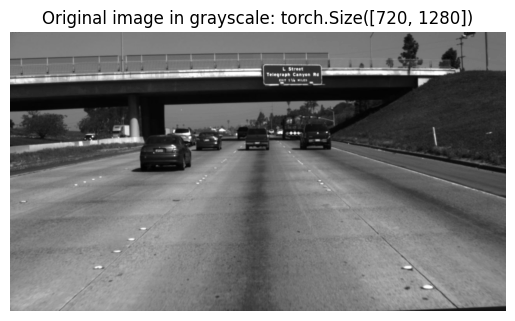

In [9]:
img_path = '/kaggle/input/tusimple/TUSimple/train_set/clips/0313-2/1050/10.jpg'
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
orig_img = torch.from_numpy(orig_img).float() 
plt.imshow(orig_img, cmap='gray');
plt.title(f"Original image in grayscale: {orig_img.shape}");
plt.axis(False);

To maintain repeatability we will use `seed_everything` function recommended [here.](https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964)

In [10]:
def seed_everything(seed: int):
    '''
    This function is used to maintain repeatability
    '''
    random.seed(seed)  
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Let us check `class LaneDataset` by taking 3 random samples from test_set.

In [11]:
def visualize_sample(im, ins):
    
    plt.figure(figsize=(7, 8));
    plt.imshow(im.squeeze(), cmap='gray');
    plt.scatter(x=ins.nonzero(as_tuple=True)[2],
                y=ins.nonzero(as_tuple=True)[1],
                marker='.', c='orange', label='Lanes');
    plt.title(f"Sample #{random_int} from test_set\n\
    Image of size {im.size(0), im.size(1), im.size(2)}");
    plt.legend();
    plt.axis(False);

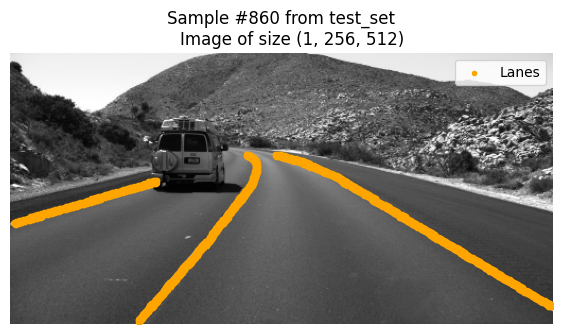

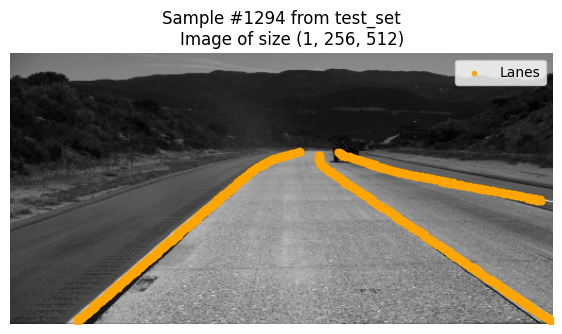

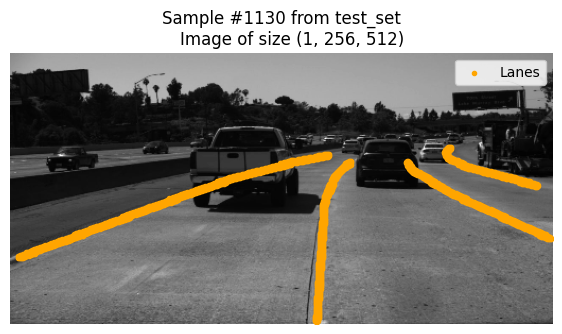

In [12]:
seed_everything(42)
lanes = LaneDataset(train=False)
for _ in range(3):
    random_int = np.random.randint(0, len(lanes)-1)
    image, _, instances = lanes[random_int]
    visualize_sample(image, instances)   

Let us create `train` dataset

In [13]:
train_set = LaneDataset(train=True)
len(train_set)

3626

Let us create `test` dataset

In [14]:
test_set = LaneDataset(train=False)
len(test_set)

2782

#### Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [15]:
seed_everything(42)

# Create a 90-10 train-validation split from trainset

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

# Divide the dataset by randomly selecting samples.
current_train, current_val = random_split(train_set, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,263 training samples
  363 validation samples


In [16]:
batch_size = 8

We will create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a `for loop`, with an iterator the entire dataset does not need to be loaded into memory.

In [17]:
seed_everything(42)

# Create the DataLoaders for our training, validation and test sets.

train_dataloader = DataLoader(
            current_train,  # The training samples.
            batch_size=batch_size, # Trains with this batch size.
            shuffle=False, num_workers=2
        )

validation_dataloader = DataLoader(
            current_val, # The validation samples.
            batch_size=batch_size, # Evaluate with this batch size.
            shuffle=False, num_workers=2
        )

test_dataloader = DataLoader(
            test_set, # The test samples.
            batch_size=batch_size,
            shuffle=False, num_workers=2
        )

Let us create a dictionary `dataloaders`, this will make usage of  `train_dataloader`, `validation_dataloader` and `test_dataloader` more convenient.

In [18]:
dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader,
    'test': test_dataloader
}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e6586b29180>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7e66640659f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e65874fc2e0>}

### Implementation of class _`ENet(nn.Module)`_

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

#### Open source example of the `ENet` neural network implementation is taken from [GitHub.](https://github.com/davidtvs/PyTorch-ENet/blob/master/models/enet.py)

In [19]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True,
                                                    dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True,
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1,
                                            dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2,
                                            dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2,
                                               asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4,
                                            dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1,
                                            dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8,
                                            dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True,
                                               padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16,
                                            dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, 
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2,
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2,
                                                       asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4,
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1,
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8,
                                                    dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True,
                                                       padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, 
                                                    dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1,
                                                       dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2,
                                                       dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2,
                                                          asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4,
                                                       padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1,
                                                       dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8,
                                                       padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True,
                                                           padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16,
                                                       padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3,
                                                         stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64,
                                                           dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1,
                                                       dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1,
                                                       dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16,
                                                           dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1,
                                                       dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim,
                                                            kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

Test the `Enet`

In [20]:
test_input = torch.ones((1, 1, 256, 512))
net = ENet(2, 4)
binary, instance = net(test_input)
print(binary.shape)
print(instance.shape)

torch.Size([1, 2, 256, 512])
torch.Size([1, 4, 256, 512])


In [21]:
seg_pred, instance_pred = net(image[None, ...]) # using already loaded image (see above)
seg_pred.shape, instance_pred.shape

(torch.Size([1, 2, 256, 512]), torch.Size([1, 4, 256, 512]))

It seems that our model is fine at least for now.

### Implementation of class _`DiscriminativeLoss(_Loss)`_

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

Code below based on [GitHub](https://github.com/IvanVassi/LaneNet-with-homography/blob/main/loss.py)

In [23]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples = target.size(0)

        dis_loss = torch.tensor(0.).to(self.device)
        var_loss = torch.tensor(0.).to(self.device)
        reg_loss = torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters = []
            sample_embedding = input[i,:,:,:]
            sample_label = target[i,:,:].squeeze()
            num_clusters = len(sample_label.unique())-1
            vals = sample_label.unique()[1:]
            sample_label = sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding = sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss = torch.tensor(0.).to(self.device)
            d_loss = torch.tensor(0.).to(self.device)
            r_loss = torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices = (sample_label == vals[j]).nonzero()
                indices = indices.squeeze()
                cluster_elements = torch.index_select(sample_embedding,1,indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss += torch.pow((torch.clamp(
                    torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum() / Nc
                r_loss += torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index == idx:
                        continue 
                    else:
                        distance = torch.norm(clusters[index]-cluster) 
                        d_loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.),2)
            var_loss += v_loss / num_clusters
            dis_loss += d_loss / (num_clusters * (num_clusters-1))
            reg_loss += r_loss / num_clusters
        return (self.alpha * (var_loss / num_samples) + 
                self.beta * (dis_loss / num_samples) + 
                self.gamma * (reg_loss/num_samples))

Test the loss.

In [24]:
lanes = LaneDataset()
im, s, ins = lanes[0]
im.shape, s.shape, ins.shape

(torch.Size([1, 256, 512]), torch.Size([256, 512]), torch.Size([1, 256, 512]))

In [26]:
instance_pred.shape

torch.Size([1, 4, 256, 512])

In [27]:
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001)(instance_pred, ins)

tensor(9.1936, grad_fn=<AddBackward0>)

A helper function to compute two losses.

In [28]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    '''
    A helper function to compute two losses.
    '''
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

### Training the model

Now we are ready to train the network. You may want to create validation subset to track metrics.

In `train_model` function we will implement the following:
-  Saving the best model

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Check the potential ability to use GPU for model training.

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [41]:
def train_model(model, optimizer, num_epochs=1):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    # Specify path
    temp_path = '/kaggle/working/temp'
    # Check whether the specified path exists or not
    isExist = os.path.exists(temp_path)
    if not isExist:
        os.mkdir(temp_path)
    best_model_params_path = os.path.join(temp_path, 'enet_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    
    best_mean_loss = 500.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        step = 0
        t0 = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print('Training in progress')
                model.train()  # Set model to training mode
            else:
                print('Validation in progress')
                model.eval()   # Set model to evaluate mode

            losses = []    

            # Iterate over data.
            for img, binary_target, instance_target in dataloaders[phase]:

                img = img.to(device)
                binary_target = binary_target.to(device)
                instance_target = instance_target.to(device)
                # Progress update every 20 batches.
                if step % 20 == 0 and not step == 0:
                    elapsed = format_time(time.time() - t0)
                    print(f'Phase {phase:}:  Batch {step:>5,}  of  {len(dataloaders[phase]):>5,}. Elapsed: {elapsed}.')
                    
                step += 1
                if step == len(dataloaders[phase]):
                    step = 0

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    binary_logits, instance_emb = model(img)

                    binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
                    loss = binary_loss + instance_loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

            mean_losses = np.array(losses).mean(axis=0)
            print(f'{phase} binary_loss: {mean_losses[0]:.4f} instance_loss: {mean_losses[1]:.4f}')

            # deep copy the model
            epoch_mean_loss = mean_losses.mean()
            if phase == 'val' and epoch_mean_loss < best_mean_loss:
                best_mean_loss = epoch_mean_loss
                torch.save(model.state_dict(), best_model_params_path)
        print('-' * 10)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean loss: {best_mean_loss:.4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

### Train and evaluate

In [38]:
enet_model = ENet(2, 4)
enet_model = enet_model.to(device)

# Observe that all parameters of the model are being optimized
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0002)

In [39]:
# Get all of the model's parameters as a list of tuples.
params = list(enet_model.named_parameters())

print(f'The {enet_model.__class__.__name__} model has {len(params)} different named parameters.\n')

The ENet model has 522 different named parameters.



In [40]:
enet_model = train_model(enet_model, optimizer, num_epochs=8)

Epoch 1/8
----------
Training in progress
Phase train:  Batch    20  of    408. Elapsed: 0:00:06.
Phase train:  Batch    40  of    408. Elapsed: 0:00:11.
Phase train:  Batch    60  of    408. Elapsed: 0:00:16.
Phase train:  Batch    80  of    408. Elapsed: 0:00:22.
Phase train:  Batch   100  of    408. Elapsed: 0:00:27.
Phase train:  Batch   120  of    408. Elapsed: 0:00:33.
Phase train:  Batch   140  of    408. Elapsed: 0:00:38.
Phase train:  Batch   160  of    408. Elapsed: 0:00:44.
Phase train:  Batch   180  of    408. Elapsed: 0:00:49.
Phase train:  Batch   200  of    408. Elapsed: 0:00:54.
Phase train:  Batch   220  of    408. Elapsed: 0:01:00.
Phase train:  Batch   240  of    408. Elapsed: 0:01:05.
Phase train:  Batch   260  of    408. Elapsed: 0:01:11.
Phase train:  Batch   280  of    408. Elapsed: 0:01:16.
Phase train:  Batch   300  of    408. Elapsed: 0:01:21.
Phase train:  Batch   320  of    408. Elapsed: 0:01:26.
Phase train:  Batch   340  of    408. Elapsed: 0:01:32.
Phase 

In [140]:
enet_eval_dataset = test_set
enet_eval_img_1, *_ = enet_eval_dataset[2700]
enet_eval_img_1 = enet_eval_img_1.to(device)

binary_logits, instance_emb = enet_model(enet_eval_img_1[None, ...])

In [141]:
enet_eval_img_1.shape, binary_logits.shape, instance_emb.shape

(torch.Size([1, 256, 512]),
 torch.Size([1, 2, 256, 512]),
 torch.Size([1, 4, 256, 512]))

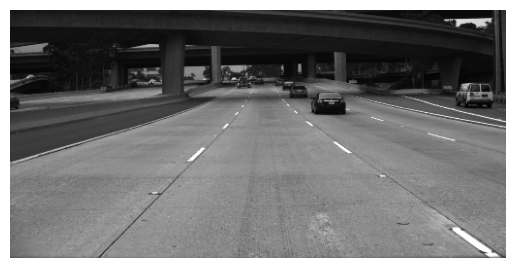

In [148]:
plt.imshow(enet_eval_img_1.squeeze().cpu(), cmap='gray');
plt.axis('off');

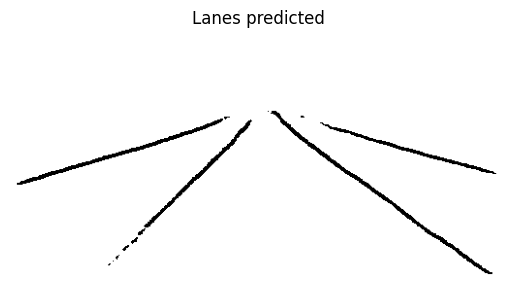

In [163]:
plt.imshow(binary_logits.squeeze().argmax(axis=0).cpu(), cmap=plt.cm.binary);
plt.title('Lanes predicted');
plt.axis('off');

We will implement a function for testing.


In [51]:
def test(model, dataloaders):

    model.to(device)
    model.eval()

    with torch.no_grad():
        losses = []

    for step, data in tqdm.tqdm(enumerate(dataloaders), total=len(dataloaders)):
        img, binary_target, instance_target = data
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)
        
        binary_logits, instance_emb = model(img)        
        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb,
                                                  binary_target, instance_target)
        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

    mean_losses = np.array(losses).mean(axis=0)


    return step + 1, mean_losses

In [52]:
step, mean_losses = test(enet_model, dataloaders['test'])
print(f'Model was tested on {step} samples')
print(f'Binary_loss: {mean_losses[0]:.4f} Instance_loss: {mean_losses[1]:.4f}')

100%|██████████| 348/348 [00:52<00:00,  6.62it/s]

Model was tested on 348 samples
Binary_loss: 0.0457 Instance_loss: 0.1816


As we can see the model performs quite well on test_set. Moreover, we may come to the conclusion that the model is not overfitted since losses on train_set and test_set are similar.

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.

`class HomographyPredictionDataset` below is based on our earlier implementation of ` class LaneDataset` with necessary modifications.

In [53]:
HNET_DEFAULT_PATH = '/kaggle/input/tusimple/TUSimple/'
HNET_DEFAULT_SIZE = (128, 64)

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=HNET_DEFAULT_PATH, train=True, size=HNET_DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        
        assert os.path.exists(self.dataset_path), f'Directory {self.dataset_path} does not exist!'
        
        # train dataset will be obtained from the following files:
        # 'label_data_0531.json' 
        # 'label_data_0313.json'
        # 'label_data_0601.json'
        if self.train: 
            json_label_files = [os.path.join(self.dataset_path, 'train_set', file)
                            for file in os.listdir(self.dataset_path + 'train_set')
                            if '.json' in file]
        
        # test dataset will be obtained from the following file:
        # 'test_label_new.json'
        else: 
            json_label_files = ['/kaggle/input/tusimple/test_label_new.json']
        
        # collecting data: [(image_path, lanes_coords)] for a dataset
        self.data = []        
        for json_label_file in json_label_files:
            try:
                with open(json_label_file, 'r') as file:
                    for line in file:
                        raw_data     = json.loads(line)
                        image_path   = raw_data["raw_file"]
                        lanes        = raw_data["lanes"]
                        h_samples    = raw_data["h_samples"]    
                        lanes_coords = []
                        for lane in lanes:
                            lane_coord = np.zeros((56, 2))
                            coord = np.array([(x, y) if x >= 0 else (-15, -15) for (x, y) in zip(lane, h_samples)])
                            lane_coord[:coord.shape[0]] = coord               
                            lanes_coords.append(lane_coord)
                            
                        self.data.append((image_path, lanes_coords))
            except BaseException:
                raise Exception(f'Something went wrong!\n\
                                File "{json_label_file.split("/")[-1]}" does not exist.')

    def __getitem__(self, idx):
        # TODO
        if self.train:
            image_path = os.path.join(self.dataset_path, 'train_set', self.data[idx][0])
        else:
            image_path = os.path.join(self.dataset_path, self.data[idx][0])
        
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        x_coeff = self.size[0] / w
        y_coeff = self.size[1] / h
        
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = torch.from_numpy(image).float().permute((2, 0, 1)) / 255
        
        lane_trajectories = self.data[idx][1].copy()       
        for lane in lane_trajectories:
            if len(lane) != 56:
                print(len(lane))
        lane_trajectories = [np.array([(x * x_coeff, y * y_coeff) for (x, y) in lane]) 
                             for lane in lane_trajectories]
        final = torch.zeros(5, 56, 2)
        final[:len(lane_trajectories)] = torch.Tensor(np.array(lane_trajectories))          
        
        return image, final.permute((0, 2, 1))

    def __len__(self):
        # TODO
        return len(self.data)

Let us check `class HomographyPredictionDataset` by taking 3 random samples from test_set.

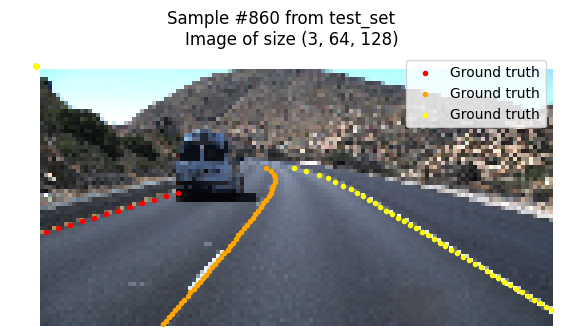

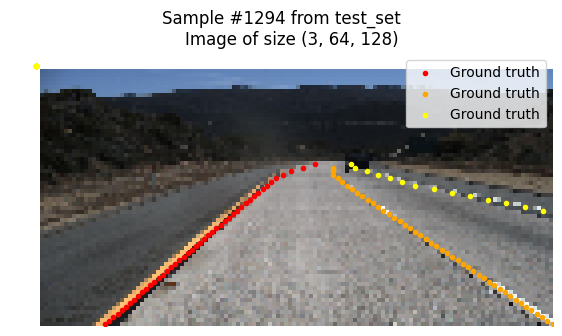

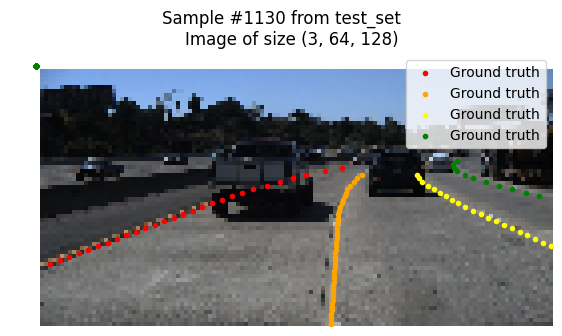

In [54]:
seed_everything(42)
test = HomographyPredictionDataset(train=False)
colors = ['red', 'orange', 'yellow', 'green', 'blue']
for _ in range(3):
    random_int = np.random.randint(0, len(test)-1)
    image, lanes = test[random_int]
    plt.figure(figsize=(7, 8));
    plt.imshow(image.permute(1, 2, 0));
    for i, lane in enumerate(lanes):
        if lane.all().item():        
            plt.scatter(x=lane[0, :],
                        y=lane[1, :],
                        marker='.', c=colors[i], label='Ground truth');
    plt.title(f"Sample #{random_int} from test_set\n\
    Image of size {image.size(0), image.size(1), image.size(2)}");
    plt.legend();
    plt.axis(False);

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.

In [55]:
# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [56]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2023-10-17 17:57:26--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg [following]
--2023-10-17 17:57:26--  https://miro.medium.com/v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Reusing existing connection to miro.medium.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 91108 (89K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’

1*b3HiwPg69Rw0L5iIM 100%[===================>]  88.97K  --.-KB/s    in 0.01s   

2023-10-17 17:57:26 (7.12 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’ saved [91108/91108]



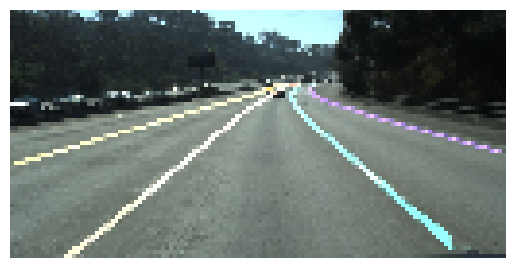

In [57]:
image = plt.imread('/kaggle/working/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg');
image = cv2.resize(image, (128, 64));
plt.imshow(image);
plt.axis('off');

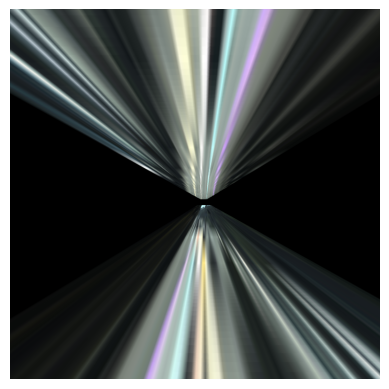

In [58]:
R_np = R.numpy()
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)));
plt.axis('off');

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

### `HNet`

Code below is based on [GitHub](https://github.com/IvanVassi/LaneNet-with-homography/blob/main/lanenet_hnet_model2.py)

In [59]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.ln1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)

        self.ln2 = nn.Linear(1024, 6)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(self.bn3(x))
        x = self.conv4(x)
        x = self.relu(self.bn4(x))
        x = self.maxpool(x)

        x = self.conv5(x)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.relu(self.bn6(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)
        x = self.ln1(x)
        x = self.relu(self.bn7(x))
        x = self.ln2(x)

        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [90]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, reduction="mean", order=2, device="cpu"):
        super(HomographyLoss, self).__init__(reduction=reduction)
        self._device = device
        self._order = order
        self._R = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )

    def forward(self, inputs, targets):
        assert inputs.shape[0] == targets.shape[0], ("Number of items in batch for inputs and targets must be the same, "
         + f"got N_inputs={inputs.shape[0]}, N_targets={targets.shape[0]}")
        losses = []
        for correction, gt_lanes in zip(inputs, targets):
            #print(correction, gt_lanes)
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue

                lane_loss = self.compute_loss_for_lane(correction, lane)
                if lane_loss is None:
                    continue

                losses.append(lane_loss)

        return torch.stack(losses).mean()

    def compute_loss_for_lane(self, correction, lane):
        H_correction_indices = [0, 1, 2, 4, 5, 7]
        H_correction = correction.flatten()
        H = self._R.flatten().clone()
        H[H_correction_indices] = H_correction
        H = H.reshape((3, 3))

        points = lane.T
        index = points.nonzero().flatten().max().item() + 1
        
        points = points[:index, :]
        ones_col = torch.ones(points.shape[0], device=device)
        P = torch.column_stack((points, ones_col)).T.to(torch.float32)
        P_transformed = H @ P

        x_transformed = P_transformed[0, :].T # N×1        
        y_transformed_squares = P_transformed[1, :] ** 2
        y_transformed = P_transformed[1, :]
        Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col)) # N×3
        w = torch.linalg.solve(Y.T @ Y, Y.T) @ x_transformed # 3×N @ N×3 @ 3×N @ N×1 = 3×1

        x_predicted = Y @ w # N×3 @ 3×1 = N×1
        P_predicted = torch.column_stack((x_predicted, y_transformed, ones_col)).T # 3×N
        P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted # 3×3 @ 3×N = 3×N

        P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])

        loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()

        return loss

Test HNet

In [61]:
homography_ds = HomographyPredictionDataset()

In [62]:
hnet = HNet()
batch = torch.stack((homography_ds[0][0], homography_ds[1][0]))
batch.size()
predicted_corrections = hnet(batch)

In [64]:
R_corrected_test_image_1 = torch.tensor(
    [
        [R[0, 0] + predicted_corrections[0][0], R[0, 1] + predicted_corrections[0][1], R[0, 2] + predicted_corrections[0][2]],
        [R[1, 0], R[1, 1] + predicted_corrections[0][3], R[1, 2] + predicted_corrections[0][4]],
        [R[2, 0], R[2, 1] + predicted_corrections[0][5], R[2, 2]],
    ]
)
R_corrected_test_image_1

tensor([[-2.4654e-02, -1.6957e+01,  3.8002e+02],
        [ 0.0000e+00, -1.6496e+01,  3.7049e+02],
        [ 0.0000e+00,  5.2152e-01,  1.0000e+00]])

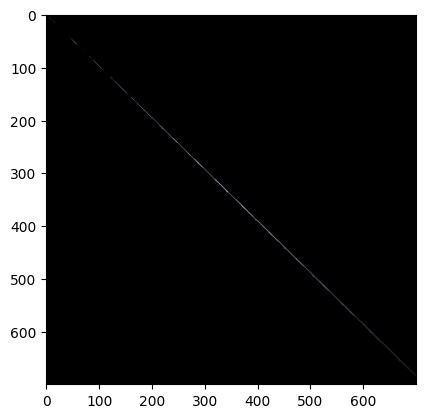

In [65]:
plt.imshow(cv2.warpPerspective(homography_ds[0][0].permute(1, 2, 0).numpy(), R_corrected_test_image_1.numpy(), dsize=(700, 700)))

In [66]:
torch.autograd.set_detect_anomaly(True)

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

Train and test datasets of `HomographyPredictionDataset` class.

In [67]:
hnet_train_set = HomographyPredictionDataset(train=True)
print(len(train_set))
hnet_test_set = HomographyPredictionDataset(train=False)
print(len(test_set))

3626
2782


#### Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [68]:
seed_everything(42)

# Create a 90-10 train-validation split from trainset

# Calculate the number of samples to include in each set.
hnet_train_size = int(0.9 * len(hnet_train_set))
hnet_val_size = len(hnet_train_set) - hnet_train_size

# Divide the dataset by randomly selecting samples.
hnet_current_train, hnet_current_val = random_split(hnet_train_set,
                                                    [hnet_train_size, hnet_val_size])

print('{:>5,} training samples'.format(hnet_train_size))
print('{:>5,} validation samples'.format(hnet_val_size))

3,263 training samples
  363 validation samples


We will create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a `for loop`, with an iterator the entire dataset does not need to be loaded into memory.

In [69]:
seed_everything(42)

# Create the DataLoaders for our training, validation and test sets.

train_dataloader = DataLoader(
            hnet_current_train,  # The training samples.
            batch_size=batch_size, # Trains with this batch size.
            shuffle=False, num_workers=2
        )

validation_dataloader = DataLoader(
            hnet_current_val, # The validation samples.
            batch_size=batch_size, # Evaluate with this batch size.
            shuffle=False, num_workers=2
        )

test_dataloader = DataLoader(
            hnet_test_set, # The test samples.
            batch_size=batch_size,
            shuffle=False, num_workers=2
        )


hnet_dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader,
    'test': test_dataloader
}
hnet_dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e65740c3310>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7e65740afe50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e6565ae2110>}

In [70]:
def hnet_train_model(model, optimizer, criterion, num_epochs=1):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    # Specify path
    temp_path = '/kaggle/working/temp'
    # Check whether the specified path exists or not
    isExist = os.path.exists(temp_path)
    if not isExist:
        os.mkdir(temp_path)
    best_model_params_path = os.path.join(temp_path, 'hnet_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    
    best_mean_loss = 30000.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        step = 0
        t0 = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:            
            if phase == 'train':
                print('Training in progress')
                model.train()  # Set model to training mode
            else:
                print('Validation in progress')
                model.eval()   # Set model to evaluate mode

            losses = []    

            # Iterate over data.
            for image, ground_truth in hnet_dataloaders[phase]:

                image = image.to(device)
                ground_truth = ground_truth.to(device) 
                	
                # Progress update every 20 batches.
                if step % 20 == 0 and not step == 0:
                    elapsed = format_time(time.time() - t0)
                    print(f'Phase {phase:}:  Batch {step:>5,}  of  {len(hnet_dataloaders[phase]):>5,}. Elapsed: {elapsed}.')
                    
                step += 1
                if step == len(hnet_dataloaders[phase]):
                    step = 0

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    coeffs = model(image)
                    loss = criterion(coeffs, ground_truth)
                    


                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()                
                
                # statistics
                losses.append(loss.detach().cpu().numpy())

            epoch_mean_loss = np.array(losses).mean()
            print(f'{phase} loss: {epoch_mean_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_mean_loss < best_mean_loss:
                best_mean_loss = epoch_mean_loss
                torch.save(model.state_dict(), best_model_params_path)
        print('-' * 10)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean loss: {best_mean_loss:.4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [91]:
lr = 1e-5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

hnet_model = HNet()
hnet_model.to(device)

params = [p for p in hnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr)

criterion = HomographyLoss(device=device)

In [92]:
# Get all of the model's parameters as a list of tuples.
params = list(hnet_model.named_parameters())

print(f'The {hnet_model.__class__.__name__} model has {len(params)} different named parameters.\n')

The HNet model has 30 different named parameters.



In [93]:
hnet = hnet_train_model(hnet_model, optimizer, criterion, num_epochs=15)

Epoch 1/15
----------
Training in progress
Phase train:  Batch    20  of    408. Elapsed: 0:00:10.
Phase train:  Batch    40  of    408. Elapsed: 0:00:19.
Phase train:  Batch    60  of    408. Elapsed: 0:00:27.
Phase train:  Batch    80  of    408. Elapsed: 0:00:37.
Phase train:  Batch   100  of    408. Elapsed: 0:00:45.
Phase train:  Batch   120  of    408. Elapsed: 0:00:55.
Phase train:  Batch   140  of    408. Elapsed: 0:01:03.
Phase train:  Batch   160  of    408. Elapsed: 0:01:12.
Phase train:  Batch   180  of    408. Elapsed: 0:01:21.
Phase train:  Batch   200  of    408. Elapsed: 0:01:30.
Phase train:  Batch   220  of    408. Elapsed: 0:01:39.
Phase train:  Batch   240  of    408. Elapsed: 0:01:48.
Phase train:  Batch   260  of    408. Elapsed: 0:01:57.
Phase train:  Batch   280  of    408. Elapsed: 0:02:06.
Phase train:  Batch   300  of    408. Elapsed: 0:02:14.
Phase train:  Batch   320  of    408. Elapsed: 0:02:23.
Phase train:  Batch   340  of    408. Elapsed: 0:02:32.
Phase

Let us evaluate performance of the model on test_set

In [94]:
def hnet_test(model, dataloaders):

    model.to(device)
    model.eval()

    with torch.no_grad():
        losses = []

    for step, data in tqdm.tqdm(enumerate(dataloaders), total=len(dataloaders)):
        image, ground_truth = data
        image = image.to(device)
        ground_truth = ground_truth.to(device) 
        
        coeffs = model(image)
        loss = HomographyLoss(device=device)(coeffs, ground_truth)
        losses.append(loss.detach().cpu().numpy())

    mean_losses = np.array(losses).mean(axis=0)

    return step + 1, mean_losses

In [96]:
step, mean_losses = hnet_test(hnet, hnet_dataloaders['test'])
print(f'Model was tested on {step} samples')
print(f'Loss: {mean_losses:.4f}')

100%|██████████| 348/348 [01:55<00:00,  3.03it/s]

Model was tested on 348 samples
Loss: 3243.8872


We obtained rather controversial results, but the model is not overfitted at least.

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

1. With HNet everything works even worse than without it, so I don't use it.
2. The result is instance segmentation + linearly fitted lanes (without projecting and reprojecting).

In [97]:
class LaneDetector:
    DEFAULT_IMAGE_SIZE = (512, 256)
    
    def __init__(self, enet, hnet=None, device="cuda", with_projection=False):
        self._enet = enet
        self._hnet = hnet
        self._default_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )
        self._eps = 1.0
        self._device = device
        self._with_projection = with_projection
  
    def __call__(self, image, y_positions=None):
        image = self._preprocess_image(image)
        if y_positions is None:
            y_positions = np.linspace(50, image.shape[2], 30)
        binary_logits, instance_embeddings = self._enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
        lanes = self._extract_lanes(instances_map)
        print(f"Detected {len(lanes)} lanes")
        if self._with_projection:
            projected_lanes = self._project_lanes(lanes)
            coefs = self._fit(projected_lanes)
            print(coefs)
            y_positions_projected = self._project_y(y_positions)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            reprojected_lanes = self._reproject(fitted_lanes)
            predicted_lanes = reprojected_lanes
        else:
            coefs = self._fit(lanes)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes
        
        predicted_lanes = self._postprocess_result(predicted_lanes)
        
        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy()
    
    def _cluster(self, segmentation_map, instance_embeddings):
        segmentation_map = segmentation_map.flatten()
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        assert segmentation_map.shape[0] == instance_embeddings.shape[0]
        
        mask_indices = segmentation_map.nonzero().flatten()

        cluster_data = instance_embeddings[mask_indices].detach().cpu()

        
        clusterer = DBSCAN(eps=self._eps)
        labels = clusterer.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=self._device)

        
        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=self._device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(self.DEFAULT_IMAGE_SIZE[::-1])

        
        return instances_map
    
    def _extract_lanes(self, instances_map, scale=False):
        lanes = []
        lane_indices = instances_map.unique()[1:]

        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1] # from (y, x) to (x, y)
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)
        
        return lanes         
    
    def _fit(self, lanes):
        coefs = []
        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=self._device))).T
            #print(x.shape, Y.shape)
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)
            
        return coefs

    def _postprocess_result(self, lanes):
        processed = []
        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)
        
        return torch.cat(processed, dim=0)
    
    def _predict_lanes(self, coefs, y_positions):
        lanes = []
        
        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=self._device).T)
        
        return lanes                
    
    def _preprocess_image(self, image):
        image = cv2.resize(image, self.DEFAULT_IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(device)
        
        return image

    def _project_lanes(self, lanes):
        projected = []
        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=self._device)
            P = torch.cat((lane, ones), dim=0)
            P_projected = self._default_homography @ P
            
            P_projected = P_projected / P_projected[2, :]

            projected.append(P_projected)
        
        return projected
    
    def _project_y(self, y_positions):
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(self._device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=self._device),
            y_positions,
            torch.ones(y_positions.shape[0], device=self._device)
        ))
        Y_projected = self._default_homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]
        
        return y_positions_projected
    
    def _reproject(self, lanes):
        reprojected = []
        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self._default_homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)
        
        return reprojected

## Test and evaluate LaneDetector

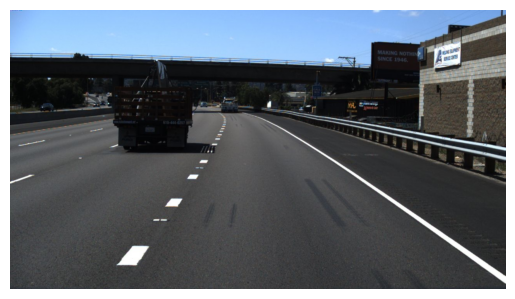

In [166]:
test_image = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0530/1492626047222176976_0/20.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image);
plt.axis('off');

In [102]:
detector = LaneDetector(enet=enet_model)
res = detector(test_image)

Detected 3 lanes


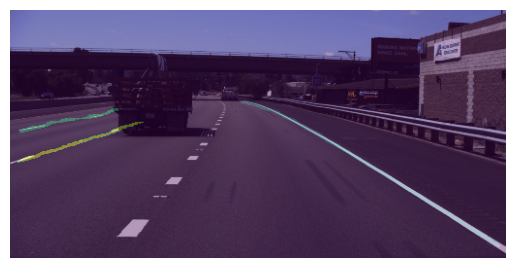

In [112]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.40);
plt.axis('off');

In the picture above we can observe detected lanes, there are 4 lanes in the picture, but only 3 of them were detected. Not perfect result but better than nothing I suppose.

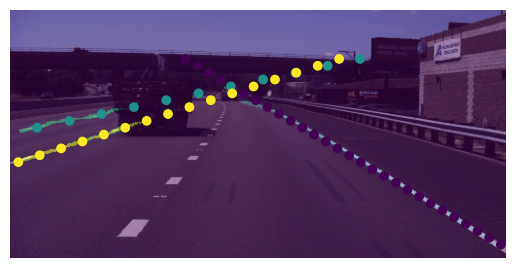

In [113]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2]);
plt.axis('off');

In the picture above we can observe detected lanes and their projections with initial Homography matrix.

In [114]:
detector = LaneDetector(enet=enet_model, hnet=hnet, with_projection=True)
res = detector(test_image)

Detected 3 lanes
[tensor([[ -1.5910],
        [958.7617]], device='cuda:0'), tensor([[ -10.0434],
        [3910.8716]], device='cuda:0'), tensor([[  -6.8263],
        [2933.7358]], device='cuda:0')]


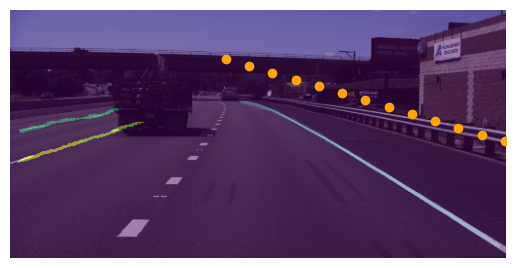

In [118]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c='orange');
plt.axis('off');

In the picture above we can observe detected lanes and their projections with Homography matrix after the training. The result is not that impressive, unfortunately.

Detected 4 lanes


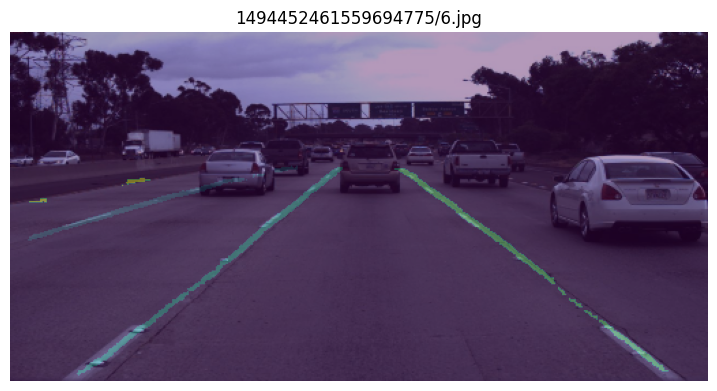

Detected 4 lanes


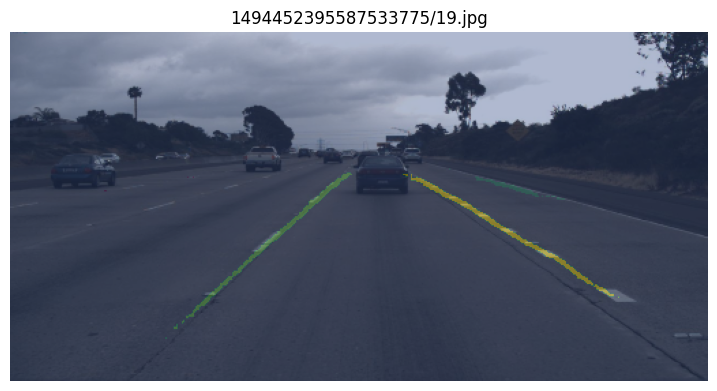

Detected 3 lanes


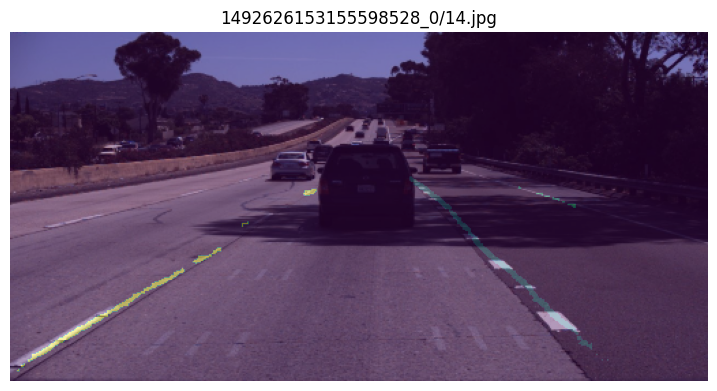

Detected 2 lanes


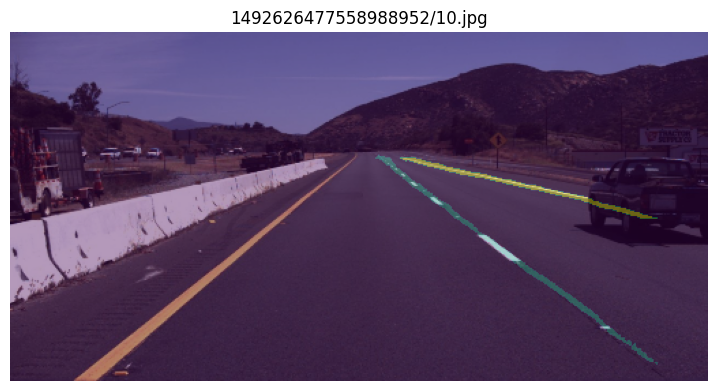

In [184]:
seed_everything(42)
detector = LaneDetector(enet=enet_model)
random_path = ['/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452461559694775/',
               '/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452395587533775/',
               '/kaggle/input/tusimple/TUSimple/test_set/clips/0530/1492626153155598528_0/',
               '/kaggle/input/tusimple/TUSimple/test_set/clips/0531/1492626477558988952/']
for i in range(4):    
    random_int = np.random.randint(0, 20)
    plt.figure(figsize=(9, 12))
    test_image = cv2.imread(f"{random_path[i] + str(random_int)}.jpg")
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    res = detector(test_image)
    plt.imshow(cv2.resize(test_image, (512, 256)))
    plt.imshow(res[0], alpha=0.40);
    plt.axis('off');
    plt.title(f"{random_path[i].split('/')[-2] + '/' + str(random_int)}.jpg")
    plt.pause(0.25);   

### Conclusion

Our Lane detector is able to recognize lanes on the roads. Unfortunately, not all of them. So, there is no limit for perfection. To increase the prediction ability of the Lane detector we probably could train  models longer, but due to lack of computational resources we had to limit the number of epochs.